In [10]:
import math, random
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchrl.data import PrioritizedReplayBuffer, ListStorage
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import csv
from wrappers import make_atari, wrap_deepmind, wrap_pytorch
%matplotlib inline

enviornment_num = "PongNoFrameskip-v4"
enviornment = make_atari(enviornment_num)
enviornment = wrap_deepmind(enviornment)
enviornment = wrap_pytorch(enviornment)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
def temporal_difference_loss_DDQN(batch_size):
    batch, info = replay_buffer.sample(batch_size, return_info=True)
    indices = info['index']
    weights = info['_weight'].to(device)

    state, action, reward, next_state, done = batch
    
    #samples a random mini-batch S, A, R, S'
    current_state = torch.FloatTensor(np.float32(state.cpu())).to(device)
    next_state = torch.FloatTensor(np.float32(next_state.cpu())).to(device)
    action     = torch.LongTensor(action.cpu()).to(device)
    reward     = torch.FloatTensor(reward.cpu()).to(device)
    done       = torch.FloatTensor(done.cpu()).to(device)


    #Compute Target Q-Values
    pre_update_q = model(current_state).detach()
    current_q_values  = model(current_state)
    #print(action.shape) 
    #print(action.size())
    selected_q_value = current_q_values.gather(1, action).squeeze(1)

    #double DQN portion 
    next_q_values = model(next_state)
    best_action = next_q_values.argmax(1, keepdim=True)
    next_q_values_target_network = model_target(next_state)
    next_q_value_target_network  = next_q_values_target_network.gather(1, best_action).squeeze(1)

    target_q_value = reward + gamma * next_q_value_target_network * (1 - done)

    td_error = (target_q_value - selected_q_value).abs()
    loss = (td_error).pow(2).mean()
    weighted_loss = (loss * weights).mean()

    optimizer.zero_grad()
    weighted_loss.backward()
    optimizer.step()

    replay_buffer.update_priority(indices, td_error + 1e-5)

    post_update_q = model(current_state)
    q_delta = (post_update_q - pre_update_q).abs().mean()
  #  print(pre_update_q)
  #  print(current_q_values)
    return weighted_loss, q_delta

In [12]:
def temporal_difference_loss_DQN(batch_size):
    batch, info = replay_buffer.sample(batch_size, return_info=True)
    indices = info['index']
    weights = info['_weight'].to(device)
    state, action, reward, next_state, done = batch
    
    #samples a random mini-batch S, A, R, S'
    current_state = torch.FloatTensor(np.float32(state.cpu())).to(device)
    next_state = torch.FloatTensor(np.float32(next_state.cpu())).to(device)
    action     = torch.LongTensor(action.cpu()).to(device)
    reward     = torch.FloatTensor(reward.cpu()).to(device)
    done       = torch.FloatTensor(done.cpu()).to(device)

    #Compute Target Q-Values
    pre_update_q = model(current_state).detach()
    current_q_values  = model(current_state)
    #print(action.shape) 
    #print(action.size())
    selected_q_value = current_q_values.gather(1, action).squeeze(1)
    
    next_q_values_target_network = model_target(next_state)
    next_q_value_target_network  = next_q_values_target_network.max(1)[0] #original

    target_q_value = reward + gamma * next_q_value_target_network * (1 - done)

    td_error = (target_q_value - selected_q_value).abs()
    loss = (td_error).pow(2).mean()
    weighted_loss = (loss * weights).mean()

    optimizer.zero_grad()
    weighted_loss.backward()
    optimizer.step()

    replay_buffer.update_priority(indices, td_error + 1e-5)

    post_update_q = model(current_state)
    q_delta = (post_update_q - pre_update_q).abs().mean()
  #  print(pre_update_q)
  #  print(current_q_values)
    return weighted_loss, q_delta

In [13]:
def plot(update_indexes, losses, episode_indexes, cumulative_rewards, q_deltas):
    clear_output(True)
    plt.figure(figsize=(30,10))

    plt.subplot(131)
    plt.title(f'Loss (Temporal Difference Error), Latest Loss Measurement: {losses[-1]:.4f}')
    plt.plot(update_indexes, losses)
    plt.xlabel('Update Index')
    plt.ylabel('Loss (MSE)')

    plt.subplot(132)
    plt.title(f'Change in Q-Value, Latest Measurement: {q_deltas[-1]:.4f}')
    plt.plot(update_indexes, q_deltas)
    plt.xlabel('Update Index')
    plt.ylabel('Q Delta')

    plt.subplot(133)
    plt.title('Cumulative Reward Over an Episode')
    plt.title(f'Cumulative Reward Over an Episode, Latest Reward: {cumulative_rewards[-1]:.1f}')
    plt.plot(episode_indexes, cumulative_rewards)
    plt.xlabel('Episode Index')
    plt.ylabel('Reward')

    plt.show()

In [14]:
def ucb(state, model, action_counts, total_steps, c):
    state = torch.FloatTensor(state).unsqueeze(0).to(device)
    q_values = model(state).detach().squeeze(0).cpu().numpy()
    
    ucb_bonus = c * np.sqrt(np.log(total_steps) / (action_counts + 1e-5)) #got divide by 0 warning
    ucb_values = q_values + ucb_bonus
    
    action = np.argmax(ucb_values)
    action_counts[action] = action_counts[action] + 1
    
    return action

In [15]:
#Note this section of code is untouched from original source code from https://github.com/higgsfield
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()

        self.input_shape = input_shape
        self.num_actions = num_actions

        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def feature_size(self):
        return self.features(torch.zeros(1, *self.input_shape)).view(1, -1).size(1)

    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = torch.FloatTensor(np.float32(state)).unsqueeze(0)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(enviornment.action_space.n)
        return action

In [16]:
#Note this section of code is just slighty modified from the source code from https://github.com/higgsfield
class Dueling_CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(Dueling_CnnDQN, self).__init__()

        self.input_shape = input_shape
        self.num_actions = num_actions

        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        # State-Value stream
        self.state_value_stream = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

        # Advantage stream
        self.advantage_stream = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) #added due to matrix multiplication issue
        state_value = self.state_value_stream(x)
        advantage = self.advantage_stream(x)
        q_values_sum = state_value + advantage - advantage.max(1, keepdim=True)[0]
        return q_values_sum

    def feature_size(self):
        return self.features(torch.zeros(1, *self.input_shape)).view(1, -1).size(1)


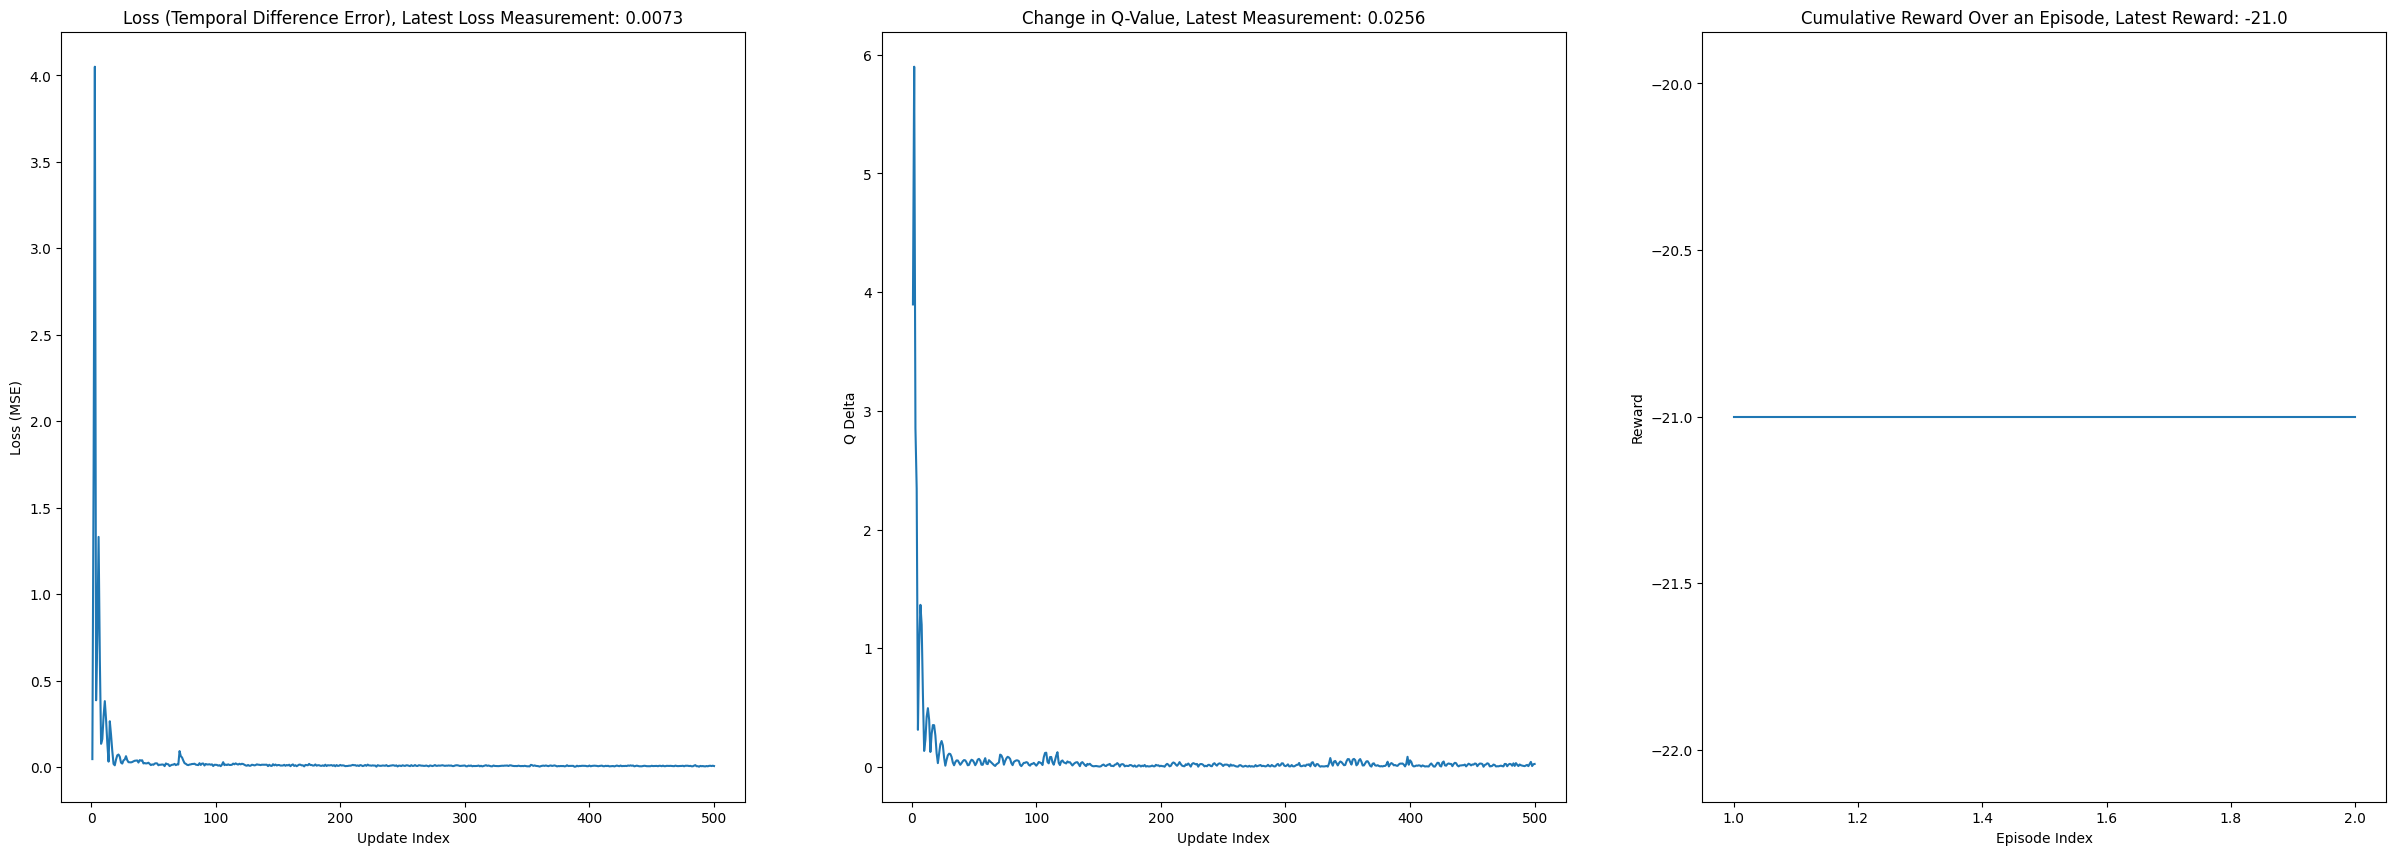

KeyboardInterrupt: 

In [17]:
timesteps = 1400000
batch_size = 128
gamma      = 0.99

losses = []
q_deltas = []

cumulative_rewards = [] #cumulative reward over an episode
episode_indexes = [] 

update_index = 1 #timesteps
update_indexes = [] 

episode_index = 1 #episode index
episode_reward = 0

action_counts = np.zeros(enviornment.action_space.n) #needed for UCB implementation

#uncomment below to enable normal DQN, comment to disable
#model = CnnDQN(enviornment.observation_space.shape, enviornment.action_space.n).to(device)
#model_target = CnnDQN(enviornment.observation_space.shape, enviornment.action_space.n).to(device)

#uncomment below to enable Dueling DQN, comment to disable
model = Dueling_CnnDQN(enviornment.observation_space.shape, enviornment.action_space.n).to(device)
model_target = Dueling_CnnDQN(enviornment.observation_space.shape, enviornment.action_space.n).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, amsgrad=True)

replay_buffer = PrioritizedReplayBuffer(alpha=0.5, beta=0.5, storage=ListStorage(100000))

state = enviornment.reset()
start_time = time.time()
for frame_idx in range(1, timesteps + 1):
    action = ucb(state, model, action_counts, frame_idx, c=1.0)
    action = action.item() if isinstance(action, torch.Tensor) else action
    next_state, reward, complete, _ = enviornment.step(action)

    state = torch.FloatTensor(state)
    action = torch.LongTensor([action])
    reward = torch.tensor(reward, dtype=torch.float) 
    next_state = torch.FloatTensor(next_state)
    complete = torch.tensor(complete, dtype=torch.float)

    series = (state, action, reward, next_state, complete)
    replay_buffer.add(series)

    state = next_state
    episode_reward = episode_reward + reward

    if complete:
        cumulative_rewards.append(episode_reward)
        episode_reward = 0
        episode_indexes.append(episode_index)
        episode_index = episode_index + 1
        state = enviornment.reset()
    
    if len(replay_buffer) > 1500:
        
        #loss, q_delta = temporal_difference_loss_DQN(batch_size) #swap to normal DQN
        loss, q_delta = temporal_difference_loss_DDQN(batch_size) #swap to Double DQN
        losses.append(loss.item())
        q_deltas.append(q_delta.item())
        update_indexes.append(update_index)
        update_index = update_index + 1

    if frame_idx % 100 == 0:  # Update target network every 100 steps
        model_target.load_state_dict(model.state_dict())

    if frame_idx % 2000 == 0:
        plot(update_indexes, losses, episode_indexes, cumulative_rewards, q_deltas)

end_time = time.time() 
difference = end_time - start_time
print(f"Atari Pong Training Time: {difference:.1f} sec")